<a href="https://colab.research.google.com/github/Land-dev/finalProject163/blob/main/163FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install ai2thor
!pip install opencv-python pycocotools matplotlib onnxruntime onnx
!pip install git+https://github.com/facebookresearch/segment-anything.git
!pip install open_clip_torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.6/68.6 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 105.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.2/182.2 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 118.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 128.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 9.1 MB/s eta 0:00:00
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-aga_m3ah
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-aga_m3ah
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=

In [4]:
!apt-get update
!apt-get install -y xvfb

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:2 https://cli.github.com/packages stable InRelease
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,151 kB]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,832 kB]
Get:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:11 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [3,532 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:13 https://ppa.launchpadcontent.net/graphics-drivers

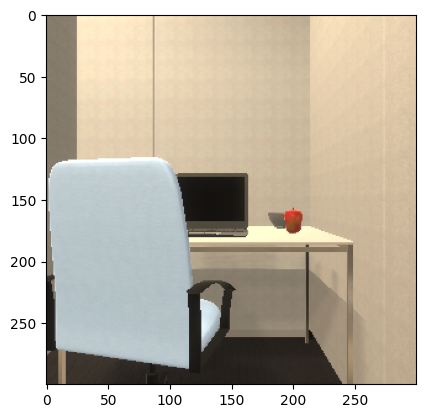

In [13]:
# Visualize the room
import matplotlib.pyplot as plt
frame = controller.last_event.frame

plt.imshow(frame)
plt.axis('on')
plt.show()

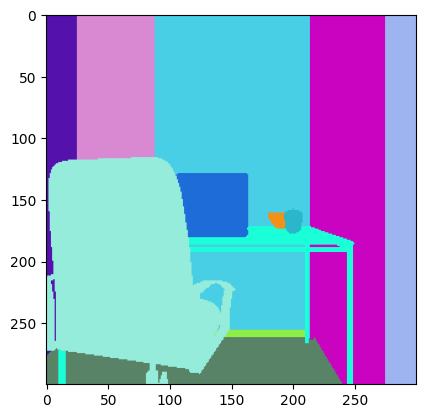

In [14]:
# Show segmentation
seg_frame = controller.last_event.instance_segmentation_frame

plt.imshow(seg_frame)
plt.axis('on')
plt.show()

In [ ]:
import os
import subprocess
import time
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from collections import Counter

# AI2-THOR
from ai2thor.controller import Controller

# OpenCLIP & SAM
import open_clip
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator

In [ ]:

# ==========================================
# 1. SETUP HEADLESS DISPLAY (Colab/Linux)
# ==========================================
print("--- Step 1: Setting up Virtual Display ---")
# Only necessary if you get "No valid X display" error
try:
    xvfb_process = subprocess.Popen(
        ["Xvfb", ":1", "-screen", "0", "1024x768x24", "+extension", "GLX", "+render"],
        stdout=subprocess.DEVNULL,
        stderr=subprocess.DEVNULL
    )
    os.environ["DISPLAY"] = ":1"
    time.sleep(2) # Give it time to start
    print("Xvfb started on :1")
except FileNotFoundError:
    print("Xvfb not found. Assuming local display or already configured.")

In [ ]:
# ==========================================
# 2. LOAD MODELS (SAM + CLIP)
# ==========================================
print("\n--- Step 2: Loading AI Models ---")
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# A. Load CLIP
clip_model, _, clip_preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion2b_s34b_b79k', device=device)
tokenizer = open_clip.get_tokenizer('ViT-B-32')

# B. Load SAM
# Ensure you have the checkpoint file: wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

if os.path.exists(sam_checkpoint):
    sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
    sam.to(device=device)
    # Higher density points for better small object detection
    mask_generator = SamAutomaticMaskGenerator(sam, points_per_side=32, pred_iou_thresh=0.86)
    print("Models loaded successfully.")
else:
    raise FileNotFoundError(f"Please download the SAM checkpoint: {sam_checkpoint}")

In [ ]:
# ==========================================
# 3. HELPER FUNCTIONS
# ==========================================

def find_best_object(controller, text_query):
    """
    Uses SAM to segment and CLIP to score objects against the query.
    Returns: best_mask (dict), crop_image (PIL), confidence_score (float)
    """
    # Clean prompt (Prompt Engineering)
    clean_query = text_query.lower().replace("find the ", "").replace("where is the ", "").replace("show me ", "")
    print(f"Scanning scene for: '{clean_query}'...")

    image_np = controller.last_event.frame

    # Generate Masks
    masks = mask_generator.generate(image_np)
    if len(masks) == 0: return None, None, 0.0

    # Crop and Prepare
    crops = []
    valid_masks = []

    for mask_data in masks:
        x, y, w, h = map(int, mask_data['bbox'])
        # Filter tiny noise
        if w < 10 or h < 10: continue

        crop = Image.fromarray(image_np[y:y+h, x:x+w])
        crops.append(crop)
        valid_masks.append(mask_data)

    if not crops: return None, None, 0.0

    # Encode with CLIP
    text_tokens = tokenizer([clean_query]).to(device)
    image_inputs = torch.stack([clip_preprocess(img) for img in crops]).to(device)

    with torch.no_grad():
        img_features = clip_model.encode_image(image_inputs)
        txt_features = clip_model.encode_text(text_tokens)

        # Normalize
        img_features /= img_features.norm(dim=-1, keepdim=True)
        txt_features /= txt_features.norm(dim=-1, keepdim=True)

        # Similarity
        probs = (100.0 * img_features @ txt_features.T).softmax(dim=0)
        values, indices = probs.topk(1)

    best_idx = indices[0].item()
    return valid_masks[best_idx], crops[best_idx], values[0].item()

def get_spatial_context(controller, target_mask):
    """
    Uses AI2-THOR Metadata + Instance Segmentation to find the parent receptacle.
    """
    event = controller.last_event
    seg_frame = event.instance_segmentation_frame

    # 1. Get pixels belonging to the SAM mask
    # We use the SAM binary mask to select pixels from the Segmentation Frame
    # format of mask['segmentation'] is boolean (H, W)
    sam_binary_mask = target_mask['segmentation']

    # Extract all color codes inside this mask
    colors_inside_mask = seg_frame[sam_binary_mask]

    # 2. Find the most common color (Mode)
    # This is more robust than just checking the center pixel
    # colors_inside_mask is a list of [R, G, B] arrays. Convert to tuple to hash.
    colors_as_tuples = [tuple(c) for c in colors_inside_mask]

    if not colors_as_tuples:
        return "Unknown"

    most_common_color, _ = Counter(colors_as_tuples).most_common(1)[0]

    # 3. Map Color -> Object ID
    object_id = event.color_to_object_id.get(most_common_color)
    if not object_id: return "Unknown (Background)"

    # 4. Look up Metadata
    obj_meta = next((o for o in event.metadata['objects'] if o['objectId'] == object_id), None)
    if not obj_meta: return "Unknown ID"

    # 5. Check Parent Receptacles
    parent_ids = obj_meta.get('parentReceptacles')

    if parent_ids:
        # Get the immediate parent (last in list)
        parent_id = parent_ids[-1]
        # Find parent name
        parent_meta = next((o for o in event.metadata['objects'] if o['objectId'] == parent_id), None)
        parent_name = parent_meta['objectType'] if parent_meta else parent_id.split("|")[0]
        return parent_name
    else:
        return "the floor"

--- Step 1: Setting up Virtual Display ---
Xvfb started on :1

--- Step 2: Loading AI Models ---
Using device: cuda
Models loaded successfully.

--- Step 3: Starting Controller ---
Scanning scene for: 'red apple'...

SUCCESS: Found object matching 'find the red apple'
Confidence: 0.00
Spatial Context: It is on Unknown ID.


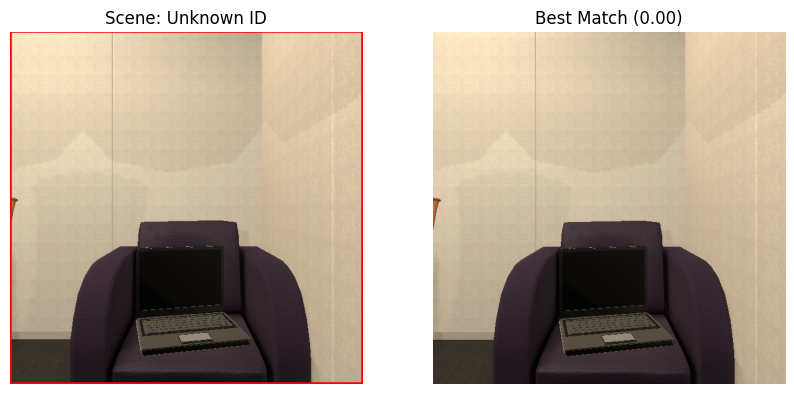

In [24]:


# ==========================================
# 4. MAIN EXECUTION
# ==========================================
print("\n--- Step 3: Starting Controller ---")
controller = Controller(
    agentMode="locobot",
    visibilityDistance=1.5,
    renderDepthImage=True,           # Useful for debug
    renderInstanceSegmentation=True, # REQUIRED for metadata lookup
    width=600,
    height=600
)

# Move somewhere interesting (optional)
# controller.step("MoveBack")
# controller.step("RotateRight")

user_query = "find the red apple"

# 1. Visual Search
best_mask, crop_img, confidence = find_best_object(controller, user_query)

if best_mask:
    # 2. Spatial Reasoning
    location_desc = get_spatial_context(controller, best_mask)

    # 3. Final Output
    print(f"\nSUCCESS: Found object matching '{user_query}'")
    print(f"Confidence: {confidence:.2f}")
    print(f"Spatial Context: It is on {location_desc}.")

    # 4. Visualize
    x, y, w, h = map(int, best_mask['bbox'])
    full_img = controller.last_event.frame.copy()

    # Draw Red Box on full image
    cv2.rectangle(full_img, (x, y), (x+w, y+h), (255, 0, 0), 3)

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(full_img)
    ax[0].set_title(f"Scene: {location_desc}")
    ax[0].axis('off')

    ax[1].imshow(crop_img)
    ax[1].set_title(f"Best Match ({confidence:.2f})")
    ax[1].axis('off')
    plt.show()

else:
    print("Could not find any objects in the scene.")